## Tensorflow Probability - Heirarchical Models: Varying Intercepts  

The last couple of days have been a huge learning curve and I've been able to implement mixture models and hierarchical meta-analyses (i.e. the eight schools problem). Today, I am going to continue the journey with hierarchical modeling, and look at varying intercepts. I will simulate some simple data and then eventually try to reproduce Richard McElreath's Chimpanzee example (see the brms version of this [here](https://bookdown.org/ajkurz/Statistical_Rethinking_recoded/multilevel-models.html)).

The "ah-ha!" moment was following [Adam Haber's examples](https://adamhaber.github.io/2019/07/08/A-Tutorial-on-Varying-Intercepts-Models-with-TensorFlow-Probability.html) which use the [JointDistributionSequential](https://www.tensorflow.org/probability/api_docs/python/tfp/distributions/JointDistributionSequential) method. The documention for JointDistributionSequential has a nice discussion on how it works. I'd encourage people to read this :) 



### Setup  

As always, we need to define our NoUTurn sampler. I am going to wrap this into a class today - over time, I will build on this and it will help me port this into real projects that I am working on.

Of course, we need to make sure we have tfp 0.8.0 and the arviz package.

In [0]:
! pip3 install -q --upgrade tensorflow-probability==0.8.0
! pip3 install -q arviz

In [2]:
import collections
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import matplotlib.pyplot as plt
import daft as daft 

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
tfb = tfp.bijectors

try:
  tf.compat.v1.enable_eager_execution()
except ValueError:
  pass

from __future__ import print_function

class MonteCarloEngine:

    def __init__(self):
        self.session = None
        self.run = tf.function(
            self.sampler, autograph=False, experimental_compile=True
        )

    def reset_session(self, config = None):
        tf.reset_default_graph()

        try:
            self.session.close()
        except:
            pass

        self.session = tf.InteractiveSession(config = config)

    def trace_function(self, samples, pkr):
        return (
            pkr.inner_results.inner_results.target_log_prob,
            pkr.inner_results.inner_results.leapfrogs_taken,
            pkr.inner_results.inner_results.has_divergence,
            pkr.inner_results.inner_results.energy,
            pkr.inner_results.inner_results.log_accept_ratio
        )

    def get_trace_stats(self, trace, statnames = ['log_likelihood', 'tree_size', 'diverging', 'energy', 'mean_tree_accept']):
      return az.from_dict(sample_stats = {k:v.numpy().T for k, v in zip(statnames, trace)})

    def compare_models(self, traces = [], labels = []):
      return az.compare({
          lab:self.get_trace_stats(trace) for lab,trace in zip(labels, traces)
      })

    def sampler(
        self, 
        model = None,    # log-probability function
        nparams = None,  # number of parameters
        inits = None,    # initialisation for parameters
        trace_fn = None, # trace function
        iters = 2000,    # number of MCMC iterations
        warmup = 1000,   # warmup iterations
        chains = 1,
        bijectors_list = None
    ):
    
        if not isinstance(inits, list):
            inits = [0.01] * nparams

        # I don't understand this part yet...
        # Dig into this in the future
        if bijectors_list is None:
            bijectors_list = [tfb.Identity()] * nparams

        kernel = tfp.mcmc.DualAveragingStepSizeAdaptation(
            tfp.mcmc.TransformedTransitionKernel(
                inner_kernel=tfp.mcmc.NoUTurnSampler(
                    target_log_prob_fn = model,
                    step_size=1.0
                ),
                bijector=[tfb.Identity()] * nparams
            ),
            target_accept_prob=.8,
            num_adaptation_steps=np.floor(0.5*warmup),
            step_size_setter_fn=lambda pkr, new_step_size: pkr._replace(
                    inner_results=pkr.inner_results._replace(step_size=new_step_size)
                ),
            step_size_getter_fn=lambda pkr: pkr.inner_results.step_size,
            log_accept_prob_getter_fn=lambda pkr: pkr.inner_results.log_accept_ratio,
        )

        samples, trace = tfp.mcmc.sample_chain(
            num_results = iters,
            num_burnin_steps = warmup,
            current_state = inits,
            kernel = kernel,
            trace_fn = trace_fn
        )

        return [samples, trace]

mcmc_engine = MonteCarloEngine()

### Simulated data 

Let's start with a very simple example. I am going to simulate three "responses" which are normally distributed and which have slightly different means.

The structure of our data/model will look as follows: 
(code to produce these plate diagrams is from the [Multilevel Modeling Primer](https://github.com/tensorflow/probability/blob/master/tensorflow_probability/examples/jupyter_notebooks/Multilevel_Modeling_Primer.ipynb))

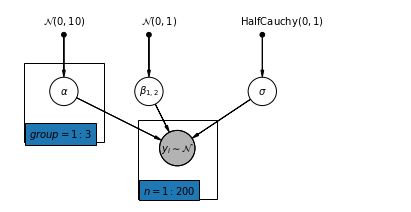

In [3]:
pgm = daft.PGM([7, 3.5])
pgm.add_node(
    daft.Node(
        "alpha_prior",
        r"$\mathcal{N}(0, 10)$",
        1,
        3,
        fixed=True,
        offset=(0,5)
    )
)
pgm.add_node(
    daft.Node(
        "beta_prior",
        r"$\mathcal{N}(0, 1)$",
        2.5,
        3,
        fixed=True,
        offset=(10,5)
    )
)
pgm.add_node(
    daft.Node(
        "sigma_prior",
        r"$\mathrm{HalfCauchy}(0, 1)$",
        4.5,
        3,
        fixed=True,
        offset=(20,5)
    )
)
pgm.add_node(daft.Node("alpha", r"$\alpha$", 1, 2))
pgm.add_node(daft.Node("beta", r"$\beta_{1,2}$", 2.5, 2))
pgm.add_node(daft.Node("sigma", r"$\sigma$", 4.5, 2))
pgm.add_node(
    daft.Node(
        "y_i", r"$y_i \sim \mathcal{N}$", 3, 1, scale=1.25, observed=True))
pgm.add_edge("alpha_prior", "alpha")
pgm.add_edge("beta_prior", "beta")
pgm.add_edge("sigma_prior", "sigma")
pgm.add_edge("sigma", "y_i")
pgm.add_edge("alpha", "y_i")
pgm.add_edge("beta", "y_i")
pgm.add_plate(daft.Plate([0.3, 1.1, 1.4, 1.4], "$group = 1:3$"))
pgm.add_plate(daft.Plate([2.3, 0.1, 1.4, 1.4], "$n = 1:200$"))

pgm.render()
plt.show()

grand mean: 14.233
global sigma: 3.533


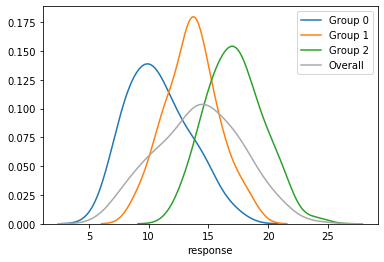

In [4]:
N = 200
K = 3
data = pd.DataFrame({
    'Group': np.random.choice(K, size=N, replace = True),
    'x1': np.random.normal(10, 3, size=N),
    'x2': np.random.poisson(3, size=N),
    'response': 0
})

data['response'] = [g + 0.7*x1 + 0.3*x2 + noise
                    for (g, x1, x2, noise) 
                    in zip(
                        np.random.normal(3*(data.Group + 1), size=N), 
                        data.x1, 
                        data.x2, 
                        np.random.normal(0, 1, size=N))]

print("grand mean: {:.3f}".format(np.mean(data.response)))
print("global sigma: {:.3f}".format(np.std(data.response)))

for x in range(K):
  sns.distplot(data[data.Group == x].response, 
               hist = False, label = "Group {}".format(x))
sns.distplot(data.response, hist = False, color = 'darkgrey', label = 'Overall')

plt.legend()
plt.show()

Arguably, these data could be represented by a mixture model, a mixture of 3 Gaussians. However, *we know the group membership* in these data, so it would be silly not use this information. Which leads us to model this as a hierarchical process.

First, let's look at the fully-pooled estimates of `response`. Let's pretend that we don't know the group structure of these data, or alternatively, that we believe that there is no differences between the groups. This is not true of course. But we'll start with this as the simplest model.

Our mode will have the form:

$$
response \sim Normal(\mu, \sigma) \\ 
\mu  = \alpha + \beta_1x_1 + \beta_2x_2 \\
\alpha \sim Normal(0, 10) \\
\beta_1, \beta_2 \sim Normal(0, 1) \\
\sigma \sim HalfCauchy(0, 1)
$$

Looking at the chart above, I would expect approximate estimates: $\beta_1 = 0.7$, $\beta_2 = 0.3$, $\alpha = 14$ and $\sigma = 4$.


Here is our `JointDistributionSequential` model:

In [0]:
model = tfd.JointDistributionSequential(
    [
     # sigma, betas and alpha 
     tfd.HalfCauchy(0.0, 1.0),             # sigma 
     tfd.Normal(0.0, 1.0),                 # beta 1
     tfd.Normal(0.0, 1.0),                 # beta 2
     tfd.Normal(0.0, 10.0),                # alpha

     # response
     lambda alpha, b2, b1, sigma: tfd.Independent(
         tfd.Normal(
             loc = alpha + b1*x1 + b2*x2,
             scale = sigma
         ),
         reinterpreted_batch_ndims=1
     )
    ]
)

Let's define our data and sample from the priors:

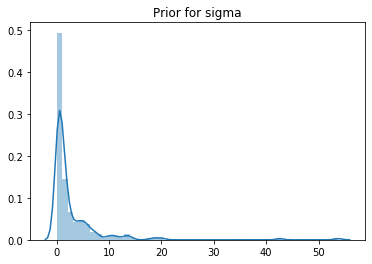

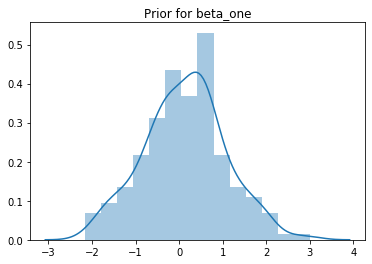

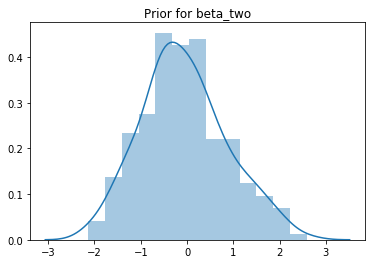

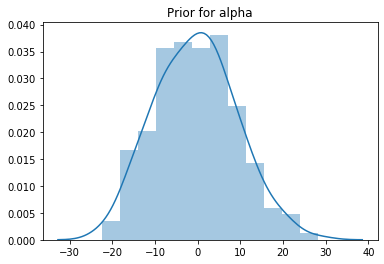

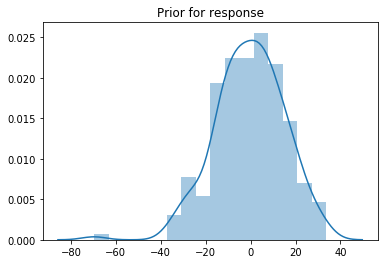

In [6]:
[response, x1, x2] = [
    data.response.astype('float32'),
    data.x1.astype('float32'),
    data.x2.astype('float32')
]

priors = model.sample(200)
params = ['sigma', 'beta_one', 'beta_two', 'alpha', 'response']

for x in range(len(params)):

  sns.distplot(
      np.reshape(priors[x], (np.prod(priors[x].shape, )))
  )
  plt.title("Prior for {}".format(params[x]))
  plt.show()

Right, let's sample from this:

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: UserWarning: tfp.edward2 module is deprecated and will be removed on 2019-12-01. Use https://github.com/google/edward2 library instead.
  exec(code_obj, self.user_global_ns, self.user_ns)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,2.835,0.144,2.567,3.106,0.004,0.003,1061.0,1036.0,1116.0,852.0,NaN
beta_one,0.742,0.072,0.596,0.867,0.004,0.003,302.0,302.0,300.0,456.0,NaN
beta_two,0.343,0.120,0.119,0.566,0.004,0.003,851.0,851.0,851.0,982.0,NaN
alpha,5.884,0.805,4.523,7.414,0.051,0.036,252.0,251.0,252.0,245.0,NaN


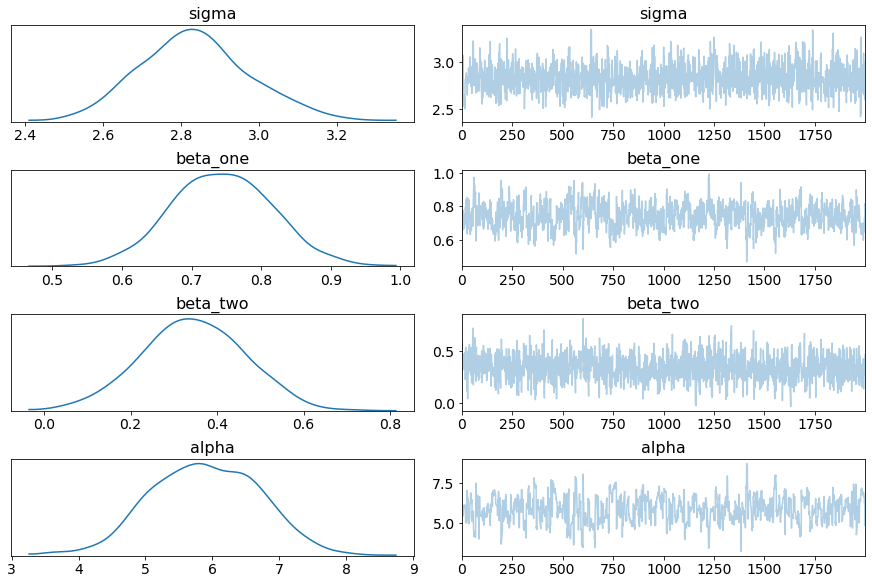

In [7]:
init_sigma, init_b1, init_b2, init_alpha, init_response = model.sample()

[sigma_, beta_one_, beta_two_, alpha_], trace_pooled_ = mcmc_engine.run(
    model = lambda sigma, b1, b2, alpha: model.log_prob([sigma, b1, b2, alpha, response]),
    nparams = 4,
    inits = [
             init_sigma,
             init_b1,
             init_b2,
             init_alpha
    ],
    trace_fn = mcmc_engine.trace_function
)

trace_pooled = az.from_tfp([sigma_, beta_one_, beta_two_, alpha_], var_names = params[:-1])
az.plot_trace(trace_pooled)

az.summary(trace_pooled)

$\beta_1$ and $\beta_2$ are looking realy good. The variance, $\sigma$ is looking pretty good as well. I'm suprised, that $\alpha$ is lower than I initially expected, but this actually makes sense because the contributions from `x1 and x2` have also been incorporated, so $\alpha$ is the intercept after controlling for `x1 and x2`. 

A good start. Let's look at posterior predictions:

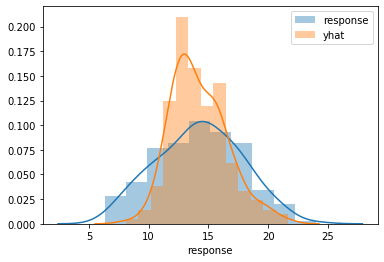

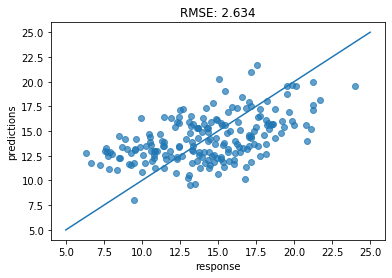

In [8]:
yhat = np.random.choice(alpha_, size = data.shape[0]) +\
        np.random.choice(beta_one_, size = data.shape[0]) * data.x1 +\
        np.random.choice(beta_two_, size = data.shape[0]) * data.x2

rmse = lambda y, yhat: np.mean(np.sqrt((y - yhat)**2))

sns.distplot(data.response, label = 'response')
sns.distplot(yhat, label = 'yhat')
plt.legend()
plt.show()

xs = np.linspace(5, 25, 100)
plt.scatter(data.response, yhat, alpha = 0.7)
plt.plot(xs, xs)
plt.xlabel("response")
plt.ylabel("predictions")
plt.title("RMSE: {:.3f}".format(rmse(data.response, yhat)))
plt.show()

These predictions really aren't that bad. But we haven't quite captured the full variance in the `response`, because we have ignored the group structure. So let's put this in.

This requires us to modify our model slightly, and include variable offsets for each of the groups:

$$
response \sim Normal(\mu, \sigma) \\ 
\mu  = \alpha + \gamma_{group} + \beta_1x_1 + \beta_2x_2 \\
\gamma_{group} \sim Normal(0, \tau) \\
\alpha \sim Normal(0, 10) \\
\beta_1, \beta_2 \sim Normal(0, 1) \\
\sigma, \tau \sim HalfCauchy(0, 1)
$$

Notice, that our variable intercepts for each group, $\gamma_{group}$ is actually an offset from the global mean, $\alpha$. For discussion, check out the link to the brms walkthrough or Chapter 12 of Statistical Rethinking.


Below, is our `JointDistributionSequential` model. Note the use of `tfd.Sample(..., sample_shape=[3])` which is the key to creating a group offset for each of the three groups. Note the sample, the list is important (try is with just `..., sample_shape=3)` and see the difference in the posterior sample shape).

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 10000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
sigma,1.305,0.067,1.184,1.431,0.001,0.000,9645.0,9461.0,9892.0,6097.0,NaN
beta_one,0.679,0.033,0.617,0.742,0.000,0.000,7152.0,7148.0,7146.0,6797.0,NaN
beta_two,0.356,0.055,0.252,0.460,0.001,0.000,9513.0,9431.0,9520.0,6835.0,NaN
alpha,5.843,2.279,1.665,10.317,0.078,0.055,864.0,864.0,959.0,696.0,NaN
tau,3.445,2.069,1.188,6.842,0.077,0.054,726.0,726.0,962.0,907.0,NaN
gamma[0],-2.722,2.254,-6.865,1.677,0.077,0.054,857.0,857.0,946.0,703.0,NaN
gamma[1],0.214,2.252,-3.772,4.734,0.077,0.065,854.0,607.0,943.0,700.0,NaN
gamma[2],3.364,2.252,-0.802,7.700,0.077,0.064,853.0,623.0,944.0,697.0,NaN


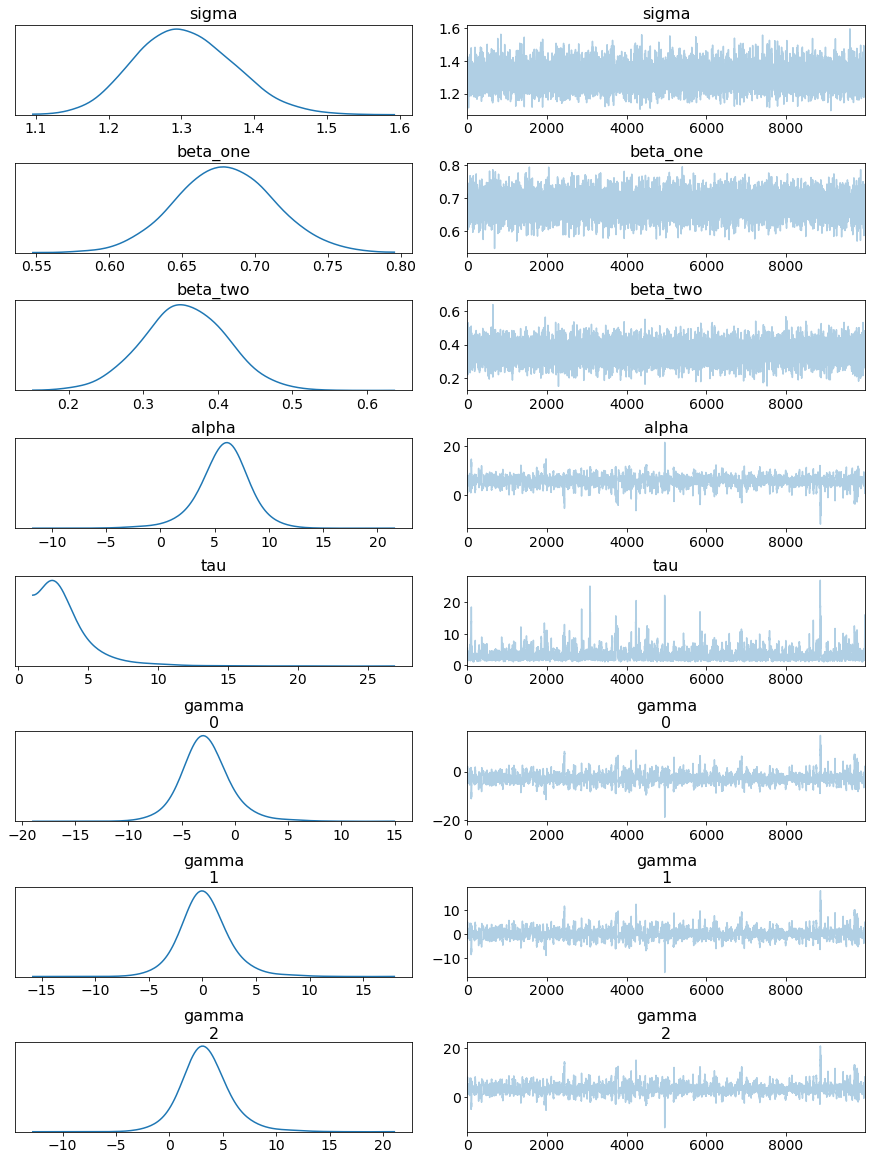

In [9]:
mcmc_engine.reset_session()
[response, x1, x2, group] = [
    data.response.astype('float32'),
    data.x1.astype('float32'),
    data.x2.astype('float32'),
    data.Group.astype('int')
]

model = tfd.JointDistributionSequential(
    [
     # sigma, betas, alpha
     tfd.HalfCauchy(0.0, 1.0),             # sigma 
     tfd.Normal(0.0, 1.0),                 # beta 1
     tfd.Normal(0.0, 1.0),                 # beta 2
     tfd.Normal(0.0, 10.0),                # alpha
     
     # gamma, group offsets
     tfd.HalfCauchy(0.0, 1.0),             # tau
     lambda tau: tfd.Sample(               # gamma
         tfd.Normal(loc = 0.0, scale = tau), 
         sample_shape = [3]
     ),                                     

     # response
     lambda gamma, tau, alpha, b2, b1, sigma: tfd.Independent(
         tfd.Normal(
             loc = alpha + tf.gather(gamma, group, axis=-1) + b1*x1 + b2*x2,
             scale = sigma
         ),
         reinterpreted_batch_ndims=1
     )
    ]
)
priors = model.sample()
params = ['sigma', 'beta_one', 'beta_two', 'alpha', 'tau', 'gamma']


[sigma_, beta_one_, beta_two_, alpha_, tau_, gamma_], trace_hierarchical_ = mcmc_engine.run(
    model = lambda sigma, b1, b2, alpha, tau, gamma: model.log_prob([sigma, b1, b2, alpha, tau, gamma, response]),
    nparams = len(params),
    inits = priors[:-1],
    iters = 10000,
    warmup = 5000,
    trace_fn = mcmc_engine.trace_function
)

trace_hier = az.from_tfp([sigma_, beta_one_, beta_two_, alpha_, tau_, gamma_], 
                     var_names = params)
az.plot_trace(trace_hier)

az.summary(trace_hier)

These estimates look great. We've still recovered $\beta_1$ and $\beta_2$ as well as the global mean, which is approximately the same and the mean for the center group. 

Importantly, we can see that the model has found that Group 0 is lower than the global mean and Group 2 is higher than the global mean. Note, that the effective sample size for $\gamma$ and $\tau$ are comparatively low - this is common for more complex models. See McElreath's discussion on pg. 374 of Statistical Rethinking.

This should lead to improved predictions:

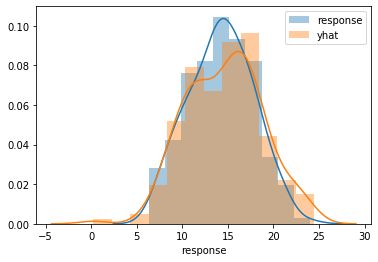

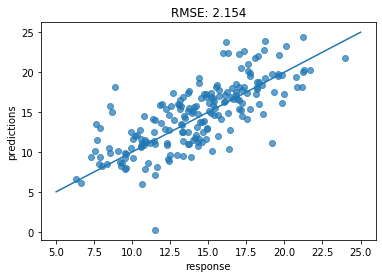

In [10]:
yhat = np.random.choice(alpha_, size = data.shape[0]) +\
        np.mean(tf.gather(gamma_, group, axis=-1), axis=0) +\
        np.random.choice(beta_one_, size = data.shape[0]) * data.x1 +\
        np.random.choice(beta_two_, size = data.shape[0]) * data.x2

rmse = lambda y, yhat: np.mean(np.sqrt((y - yhat)**2))

sns.distplot(data.response, label = 'response')
sns.distplot(yhat, label = 'yhat')
plt.legend()
plt.show()

xs = np.linspace(5, 25, 100)
plt.scatter(data.response, yhat, alpha = 0.7)
plt.plot(xs, xs)
plt.xlabel("response")
plt.ylabel("predictions")
plt.title("RMSE: {:.3f}".format(rmse(data.response, yhat)))
plt.show()

This *is* a huge improvement in the predictions. The density plot shows that we have better captured the variability. The scatter plot shows stronger correlation, smaller residuals and a lower RMSE (improved from 2.5 previously to 2).

We can also use the trace statistics to compare these two models more formally. ArviZ has a `compare` function which uses the log_likelihood to compare models based on the WAIC. See the [documentation for az.compare](https://arviz-devs.github.io/arviz/generated/arviz.compare.html). Or even better, read what [Vehtari, Gelman and Gabry](http://www.stat.columbia.edu/~gelman/research/unpublished/loo_stan.pdf) have to say about Bayesian model comparison.

I've borrowed and tweaked again from Adam Haber and created a `compare_models()` method in the mcmc_engine:

In [11]:
mcmc_engine.compare_models(
    traces=[trace_pooled_, trace_hierarchical_], 
    labels=['pooled', 'hierarchical']
)

/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1143: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  """


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
hierarchical,0,717.613,5.66542,0,1,4.28405e-14,0,True,deviance
pooled,1,1003.32,1.97588,285.703,9.12755e-63,4.28405e-14,0,True,deviance


We can see that the hierarchical model has a much lower WAIC, which supports the lower RMSE that we observed. 

There is a small amount of parameter pooling (p_waic = 6, which is slightly smaller than the 8 parameters the full model would have had).

Consequently, our hierarchical model has been assigned *all* of the posterior weight. There's enough evidence here to favour our hierarchical model over the fully-pooled model.

## Chimpanzees  

Let's turn to some more interesting data. I am going to step through the analysis of Chimpanzee data that Richard McElreath performs in Statistical Rethinking. 

The plan of attack is:  

  - begin with a simple interaction model (see m10.3, pg. 295, Statistical Rethinking)  
  - extend this to a fully-saturated model, with a separate intercept for each chimp (see m10.4, pg. 299, Statistical Rethinking)  
  - extend this to a hierarchical model with variable offsets for each chimp (see m12.4, pg. 372, Statistical Rethinking)  
  - extend this to a hierarchical model with variable offsets for each chimp and each block (see m12.5, pg. 373, Statistical Rethinking)  

Obviously, I hope to reproduce the results that McElreath obtained. It will also be a good chance to compare models of increasing complexity and perform a rudimentary model selection.  

### About the data  

This is quite a cool, if small, dataset. It's based on an experiment to test whether chimpanzees display "pro-social" (as opposed to "anti-social") tendencies. 

Consider a thought experiment where two people sit opposite each other at a table. The table contains two levers, one to the left and one to the right of the subject. One lever is setup, so that if the subject pulls it, both the subject and his partner (on the other side of the table) receive a plate of food each. The other lever is setup, so that if it is pulled, the subject receives a plate of food, but their partner receives an empty plate.

"When human students participate in an experiment like this, they nearly always choose the lever linked to two pieces of food, the prosocial option, but only when another student sits on the opposite side of the table" (p. 293, Statistical Rethinking, McElreath). The question is whether a chimpanzee displays the same prosocial tendency?

Here is the data:



In [12]:
chimps = pd.read_csv("https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/chimpanzees.csv", sep=";")
chimps

,actor,recipient,condition,block,trial,prosoc_left,chose_prosoc,pulled_left
0,1,NaN,0,1,2,0,1,0
1,1,NaN,0,1,4,0,0,1
2,1,NaN,0,1,6,1,0,0
3,1,NaN,0,1,8,0,1,0
4,1,NaN,0,1,10,1,1,1
...,...,...,...,...,...,...,...,...
499,7,4.0,1,6,64,1,1,1
500,7,6.0,1,6,66,1,1,1
501,7,3.0,1,6,68,0,0,1
502,7,7.0,1,6,70,0,0,1


We're interested in the:  
  - `actor` (id for each chimp),   
  - `block` (id for the day that the trial was performed on)  
  - `pulled_left` (indicator indicating whether the chimpanzee pulled the left-hand (1), otherwise the right-hand (0) lever)  
  - `prosoc_left` (indicator as to whether the left-hand lever was the prosocial (1) option or not (0))  
  - `condition` (indicator as to whether the subject had a partner on the other side of the table (1) or not (0))  

### m10.3  

This is the simplest model that we will consider. It is an interaction model as follows:  

$$
L_i \sim Binomial(1, p_i)  \\ 
logit(p_i) = \alpha + (\beta_p + \beta_{pc}C_i)P_i \\  
\alpha \sim Normal(0, 10) \\ 
\beta_p \sim Normal(0, 10) \\ 
\beta_{pc} \sim Normal(0, 10)
$$

Again, refer to Statistical Rethinking (pg 293) for a discussion. Or, lookup the BRMS version online.

Let's fit this:

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
alpha,0.048,0.126,-0.195,0.286,0.004,0.003,1167.0,1167.0,1168.0,1278.0,NaN
beta_p,0.618,0.227,0.197,1.040,0.009,0.006,641.0,641.0,638.0,558.0,NaN
beta_pc,-0.108,0.273,-0.656,0.379,0.011,0.009,581.0,483.0,589.0,616.0,NaN


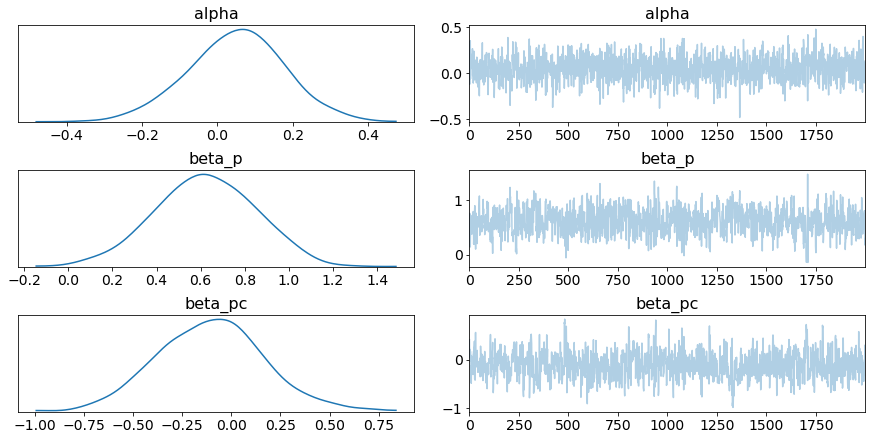

In [13]:
mcmc_engine.reset_session()

[pulled_left, prosocial, condition] = [
    chimps.pulled_left.astype('float32'),
    chimps.prosoc_left.astype('float32'),
    chimps.condition.astype('float32')
]

m10_3 = tfd.JointDistributionSequential(
    [
     # alpha, beta_p, beta_pc 
     tfd.Normal(0.0, 10.0),                # alpha
     tfd.Normal(0.0, 10.0),                # beta_p
     tfd.Normal(0.0, 10.0),                # beta_pc                                   

     # pulled_left
     lambda beta_pc, beta_p, alpha: tfd.Independent(
         tfd.Binomial(
             total_count = 1,
             logits = alpha + (beta_p + beta_pc * condition) * prosocial
         ),
         reinterpreted_batch_ndims=1
     )
    ]
)
priors = m10_3.sample()
params = ['alpha', 'beta_p', 'beta_pc']


[alpha_, beta_p_, beta_pc_], trace_m10_3_ = mcmc_engine.run(
    model = lambda alpha, beta_p, beta_pc: m10_3.log_prob([alpha, beta_p, beta_pc, pulled_left]),
    nparams = len(params),
    inits = priors[:-1],
    trace_fn = mcmc_engine.trace_function
)

trace_m10_3 = az.from_tfp([alpha_, beta_p_, beta_pc_], var_names = params)
az.plot_trace(trace_m10_3)

az.summary(trace_m10_3)

These results match those reported by McElreath ($\alpha = 0.05, \ \beta_p = 0.61, \ \beta_{pc} = -0.1$).  

### M10.4  

This model extends on the one above and introduces a unique intercept for each actor. The form of the model is:  

$$
L_i \sim Binomial(1, p_i)  \\ 
logit(p_i) = \alpha_{actor} + (\beta_p + \beta_{pc}C_i)P_i \\  
\alpha_{actor} \sim Normal(0, 10) \\ 
\beta_p \sim Normal(0, 10) \\ 
\beta_{pc} \sim Normal(0, 10)
$$

And fitting this:

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10.4,0,588.888,5.31271,0,1,4.28405e-14,0,True,deviance
m10.3,1,700.967,1.5963,112.079,4.59482e-25,4.28405e-14,0,True,deviance


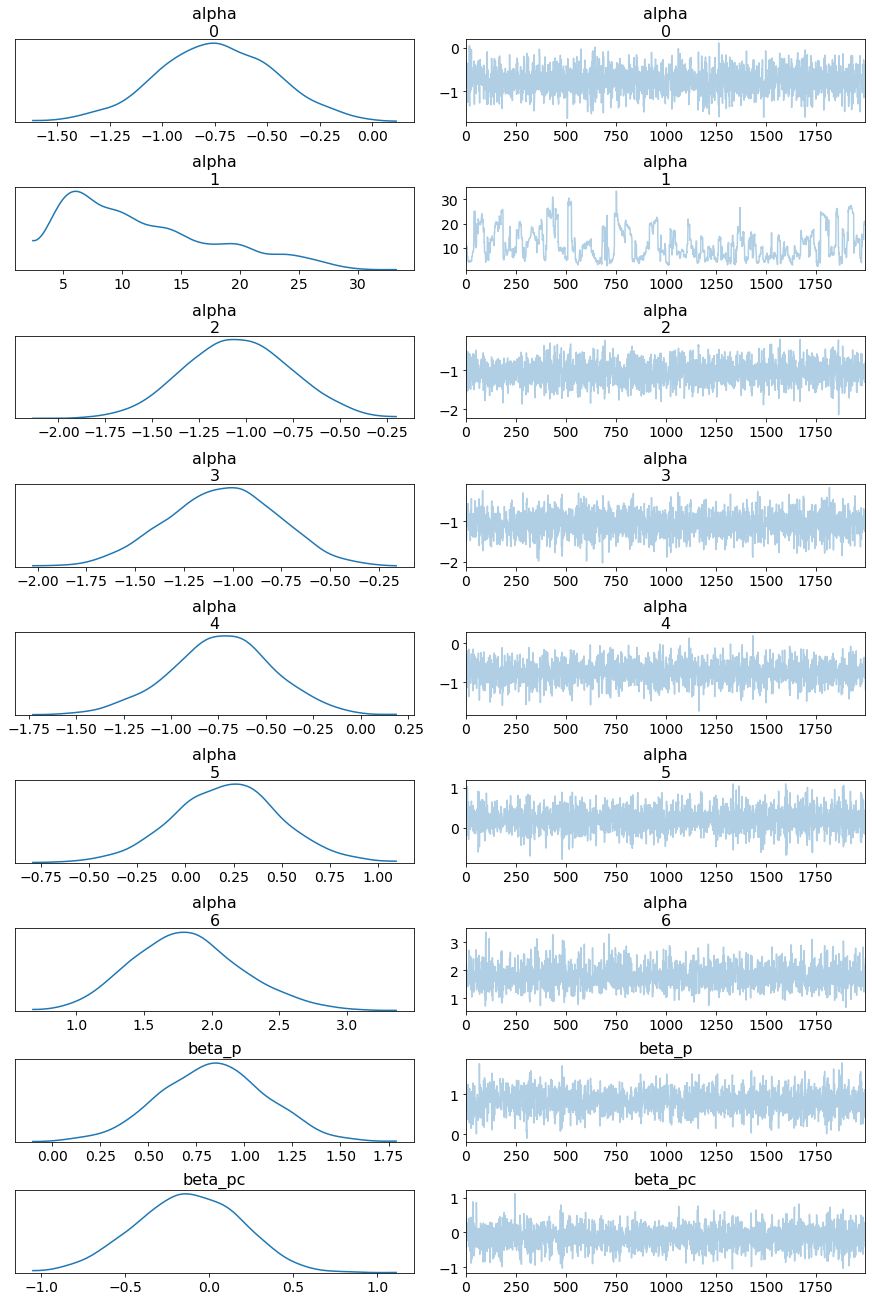

In [14]:
mcmc_engine.reset_session()

[pulled_left, prosocial, condition, actor, nactors] = [
    chimps.pulled_left.astype('float32'),
    chimps.prosoc_left.astype('float32'),
    chimps.condition.astype('float32'),
    chimps.actor.astype('int') - 1,  # -1 because python is zero-indexed
    max(chimps.actor)
]

m10_4 = tfd.JointDistributionSequential([
     
     # alpha_actor
     tfd.Sample(
         tfd.Normal(0.0, 10.0),
         sample_shape = [nactors]
     ),
     # beta_p, beta_pc 
     tfd.Normal(0.0, 10.0),                # beta_p
     tfd.Normal(0.0, 10.0),                # beta_pc 

     # pulled_left
     lambda beta_pc, beta_p, alpha: tfd.Independent(
         tfd.Binomial(
             total_count = 1,
             logits = tf.gather(alpha, actor, axis=-1) + (beta_p + beta_pc * condition) * prosocial
         ),
         reinterpreted_batch_ndims=1
     )
])
priors = m10_4.sample()
params = ['alpha', 'beta_p', 'beta_pc']


[alpha_, beta_p_, beta_pc_], trace_m10_4_ = mcmc_engine.run(
    model = lambda alpha, beta_p, beta_pc: m10_4.log_prob([alpha, beta_p, beta_pc, pulled_left]),
    nparams = len(params),
    inits = priors[:-1],
    trace_fn = mcmc_engine.trace_function
)

trace_m10_4 = az.from_tfp([alpha_, beta_p_, beta_pc_], var_names = params)
az.plot_trace(trace_m10_4)

az.summary(trace_m10_4)

mcmc_engine.compare_models(traces = [trace_m10_3_, trace_m10_4_], labels = ["m10.3", "m10.4"])

Again, these results agree with McElreath's. M10.4 is a "better fit" to the data compared to M10.3.  

### M12.4  

This should be interesting to compare to M10.4. We will adjust the model to have hierarchical intercepts for the actor. Hopefully, this will lead to parameter pooling and a lower number of effective parameters.

The form of the model will be:

$$
L_i \sim Binomial(1, p_i)  \\ 
logit(p_i) = \alpha + \gamma_{actor} + (\beta_p + \beta_{pc}C_i)P_i \\  
\alpha \sim Normal(0, 10) \\ 
\gamma_{actor} \sim Normal(0, \sigma_{actor}) \\ 
\beta_p \sim Normal(0, 10) \\ 
\beta_{pc} \sim Normal(0, 10) \\ 
\sigma_{actor} \sim HalfCauchy(0, 1)
$$

As with my simulated example, $\gamma_{actor}$ is centered around zero, thus, represents offsets from $\alpha$ 

And fitting this:

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

           mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
alpha     0.541  0.938  -1.004    2.550  ...   171.0     300.0     285.0    NaN
beta_p    0.831  0.261   0.352    1.337  ...  1797.0    1799.0    1661.0    NaN
beta_pc  -0.144  0.301  -0.713    0.416  ...  1253.0    2017.0    1490.0    NaN
sigma     2.312  0.956   0.941    4.026  ...   212.0     307.0     289.0    NaN
gamma[0] -1.255  0.956  -3.288    0.300  ...   192.0     307.0     309.0    NaN
gamma[1]  4.249  1.891   1.463    7.473  ...   204.0     288.0     326.0    NaN
gamma[2] -1.561  0.968  -3.589    0.114  ...   213.0     312.0     275.0    NaN
gamma[3] -1.562  0.960  -3.552    0.067  ...   206.0     313.0     300.0    NaN
gamma[4] -1.262  0.953  -3.142    0.481  ...   195.0     317.0     319.0    NaN
gamma[5] -0.316  0.960  -2.348    1.338  ...   181.0     317.0     282.0    NaN
gamma[6]  1.207  0.957  -0.679    2.998  ...   329.0     339.0     395.0    NaN

[11 rows x 11 columns]


/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1126: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "
/usr/local/lib/python3.6/dist-packages/arviz/stats/stats.py:1143: UserWarning: The point-wise WAIC is the same with the sum WAIC, please double check
            the Observed RV in your model to make sure it returns element-wise logp.
            
  """


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m10.4,0,588.888,5.31271,0,0.602996,4.22328e-14,0,True,deviance
m12.4,1,589.724,8.08946,0.835926,0.397004,4.22328e-14,0,True,deviance
m10.3,2,700.967,1.5963,112.079,2.77066e-25,4.22328e-14,0,True,deviance


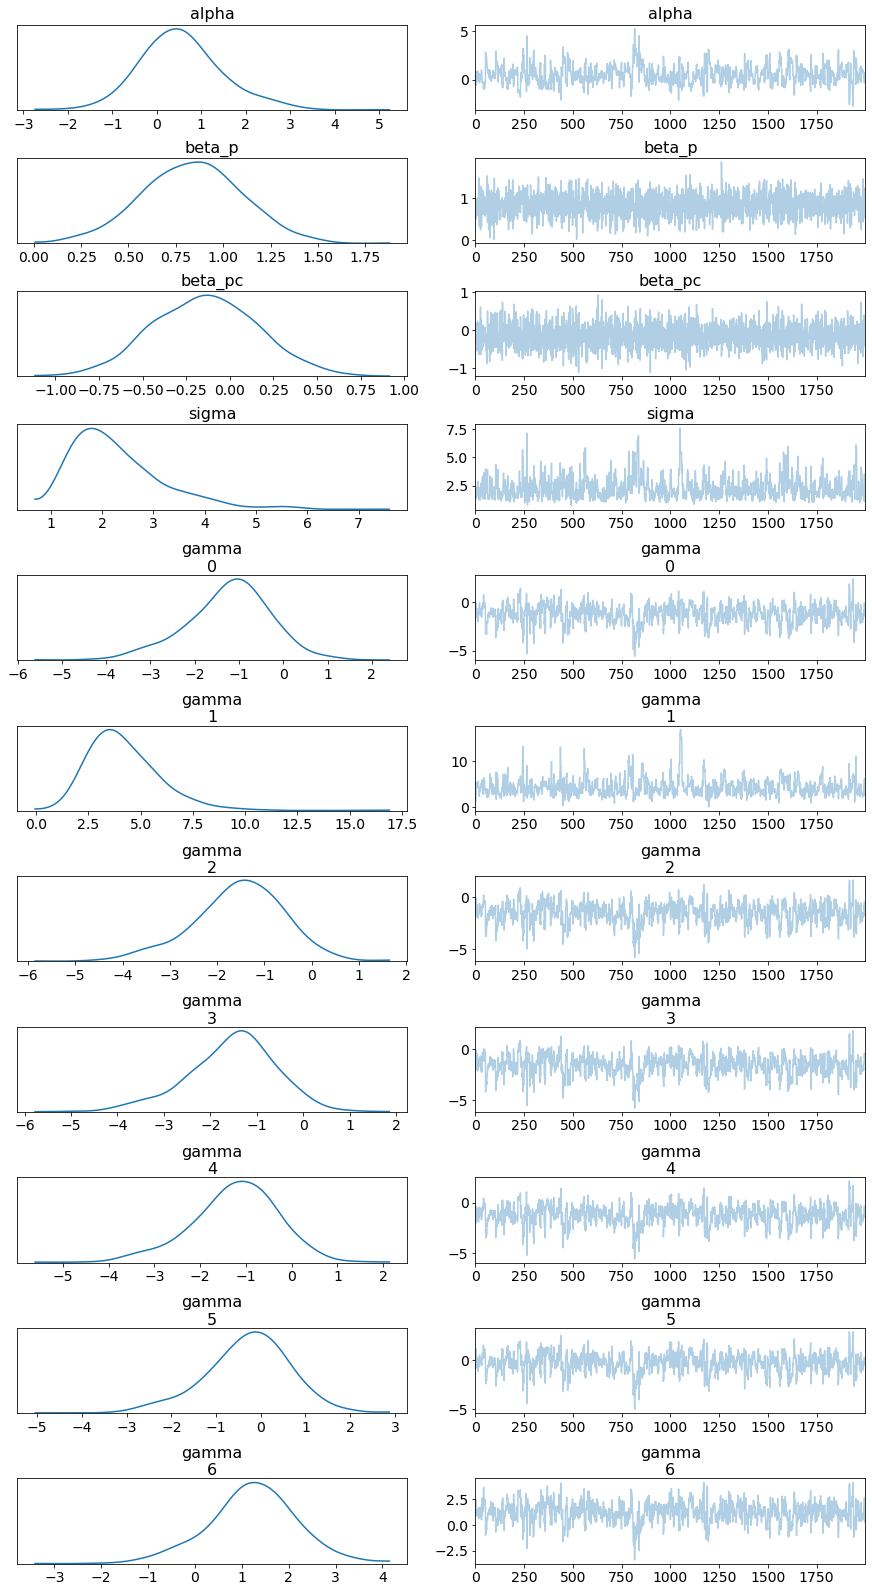

In [15]:
mcmc_engine.reset_session()

[pulled_left, prosocial, condition, actor, nactors] = [
    chimps.pulled_left.astype('float32'),
    chimps.prosoc_left.astype('float32'),
    chimps.condition.astype('float32'),
    chimps.actor.astype('int') - 1,  # -1 because python is zero-indexed
    max(chimps.actor)
]

m12_4 = tfd.JointDistributionSequential([
     
     # alpha
     tfd.Normal(0.0, 10.0),                # alpha
     
     # beta_p, beta_pc 
     tfd.Normal(0.0, 10.0),                # beta_p
     tfd.Normal(0.0, 10.0),                # beta_pc 

     # sigma
     tfd.HalfCauchy(0.0, 1.0),             # sigma

     # gamma_actor                         # gamma
     lambda sigma: tfd.Sample(
         tfd.Normal(0.0, sigma),
         sample_shape = [nactors]
     ),

     # pulled_left
     lambda gamma, sigma, beta_pc, beta_p, alpha: tfd.Independent(
         tfd.Binomial(
             total_count = 1,
             logits = (
                 alpha + 
                 tf.gather(gamma, actor, axis=-1) +
                 (beta_p + beta_pc * condition) * prosocial
             )
         ),
         reinterpreted_batch_ndims=1
     )
])
priors = m12_4.sample()
params = ['alpha', 'beta_p', 'beta_pc', 'sigma', 'gamma']


[alpha_, beta_p_, beta_pc_, sigma_, gamma_], trace_m12_4_ = mcmc_engine.run(
    model = lambda alpha, beta_p, beta_pc, sigma, gamma: m12_4.log_prob([alpha, beta_p, beta_pc, sigma, gamma, pulled_left]),
    nparams = len(params),
    inits = priors[:-1],
    trace_fn = mcmc_engine.trace_function
)

trace_m12_4 = az.from_tfp([alpha_, beta_p_, beta_pc_, sigma_, gamma_], var_names = params)
az.plot_trace(trace_m12_4)

print(az.summary(trace_m12_4))

mcmc_engine.compare_models(traces = [trace_m10_3_, trace_m10_4_, trace_m12_4_], labels = ["m10.3", "m10.4", "m12.4"])

McElreath doesn't print out the `precis` output for this model. But the estimates here are very similar to those he does print for the next model.

Looking at the model comparison, there is no evidence to favour between m10.4 and m12.4. Both of these simply give a subtly different perspective on the data.  

### M12.5  

Finally, let's add a second variable offset, this time for block. The model will have the form:


$$
L_i \sim Binomial(1, p_i)  \\ 
logit(p_i) = \alpha + \gamma_{actor} + \delta_{block} + (\beta_p + \beta_{pc}C_i)P_i \\  
\alpha \sim Normal(0, 10) \\ 
\gamma_{actor} \sim Normal(0, \sigma_{actor}) \\ 
\delta_{block} \sim Normal(0, \tau_{block}) \\
\beta_p \sim Normal(0, 10) \\ 
\beta_{pc} \sim Normal(0, 10) \\ 
\sigma_{actor}, \tau_{block} \sim HalfCauchy(0, 1)
$$


And fitting this:


arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 50000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNIN

           mean     sd  hpd_3%  hpd_97%  ...  ess_sd  ess_bulk  ess_tail  r_hat
alpha     0.258  0.689  -1.069    1.644  ...   135.0     139.0     246.0    NaN
beta_p    0.781  0.249   0.314    1.249  ...  2719.0    2719.0    5701.0    NaN
beta_pc  -0.103  0.293  -0.655    0.447  ...  2288.0    2290.0    4352.0    NaN
sigma     2.169  0.647   1.071    3.440  ...   272.0     292.0     477.0    NaN
gamma[0] -0.983  0.715  -2.422    0.400  ...   113.0     115.0     207.0    NaN
gamma[1]  4.337  1.370   1.944    7.068  ...   155.0     167.0     241.0    NaN
gamma[2] -1.287  0.725  -2.817    0.094  ...   112.0     114.0     199.0    NaN
gamma[3] -1.301  0.725  -2.726    0.185  ...   107.0     110.0     186.0    NaN
gamma[4] -0.979  0.719  -2.473    0.392  ...   116.0     118.0     202.0    NaN
gamma[5] -0.023  0.718  -1.438    1.390  ...   116.0     119.0     208.0    NaN
gamma[6]  1.525  0.760   0.051    2.954  ...   122.0     125.0     218.0    NaN
tau       0.711  0.232   0.500    1.140 

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
m12.5,0,588.398,12.0003,0,0.4351,4.16162e-14,0,True,deviance
m10.4,1,588.888,5.31271,0.489548,0.340632,4.16162e-14,0,True,deviance
m12.4,2,589.724,8.08946,1.32547,0.224268,4.16162e-14,0,True,deviance
m10.3,3,700.967,1.5963,112.569,1.56514e-25,4.16162e-14,0,True,deviance


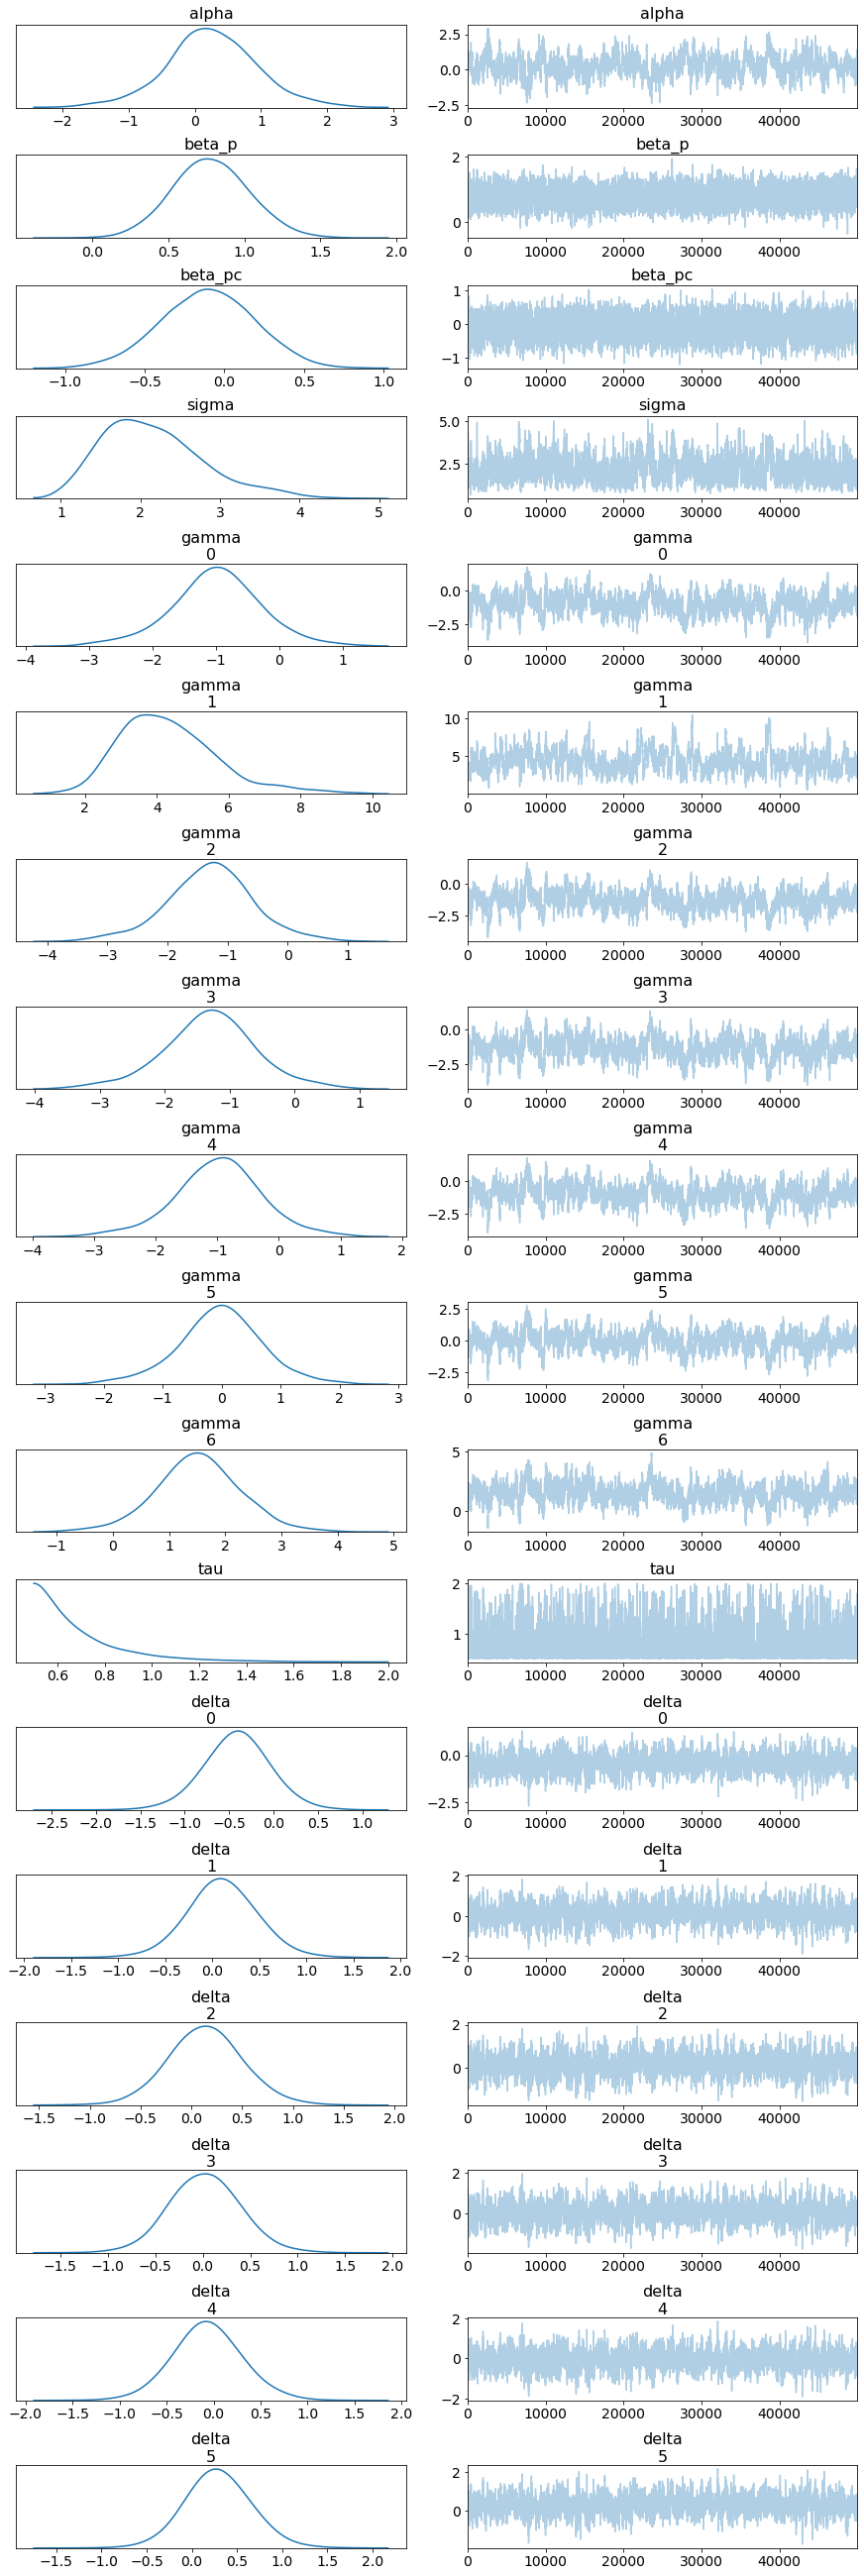

In [16]:
mcmc_engine.reset_session()

[pulled_left, prosocial, condition, actor, block, nactors, nblocks] = [
    chimps.pulled_left.astype('float32'),
    chimps.prosoc_left.astype('float32'),
    chimps.condition.astype('float32'),
    chimps.actor.astype('int') - 1,  # -1 because python is zero-indexed
    chimps.block.astype('int') - 1,
    max(chimps.actor),
    max(chimps.block)
]

m12_5 = tfd.JointDistributionSequential([
     
     # alpha
     tfd.Normal(0.0, 1.0, name='alpha'),          # alpha
     
     # beta_p, beta_pc 
     tfd.Normal(0.0, 1.0, name = 'beta_p'),       # beta_p
     tfd.Normal(0.0, 1.0, name='beta_pc'),        # beta_pc 

     # sigma
     tfd.HalfNormal(2.0, name='sigma'),       # sigma_actor
     # gamma_actor                         # gamma_actor
     lambda sigma: tfd.Sample(
         tfd.Normal(0.0, scale = sigma),
         sample_shape = [nactors],
         name='gamma'
     ),

     # tau                                 # tau_block
     tfd.Uniform(0.5, 2.0, name='tau'),
     # delta_block                         # delta_block
     lambda tau: tfd.Sample(
         tfd.Normal(0.0, scale = tau),
         sample_shape=[nblocks],
         name='delta'
     ),

     # pulled_left
     lambda delta, _tau, gamma, _sigma, beta_pc, beta_p, alpha: tfd.Independent(
         tfd.Binomial(
             total_count = 1,
             logits = (
                 alpha + 
                 tf.gather(gamma, actor, axis=-1) +
                 tf.gather(delta, block, axis=-1) +
                 (beta_p + beta_pc * condition) * prosocial
             )
         ),
         reinterpreted_batch_ndims=1
     )
])
priors = m12_5.sample()
params = ['alpha', 'beta_p', 'beta_pc', 'sigma', 'gamma', 'tau', 'delta']


[alpha_, beta_p_, beta_pc_, sigma_, gamma_, tau_, delta_], trace_m12_5_ = mcmc_engine.run(
    model = lambda alpha, beta_p, beta_pc, sigma, gamma, tau, delta: m12_5.log_prob([alpha, beta_p, beta_pc, sigma, gamma, tau, delta, pulled_left]),
    nparams = len(params),
    inits = priors[:-1],
    iters = 50000,
    warmup = 40000,
    trace_fn = mcmc_engine.trace_function
)

trace_m12_5 = az.from_tfp([alpha_, beta_p_, beta_pc_, sigma_, gamma_, tau_, delta_], var_names = params)
az.plot_trace(trace_m12_5)

print(az.summary(trace_m12_5))

mcmc_engine.compare_models(traces = [trace_m10_3_, trace_m10_4_, trace_m12_4_, trace_m12_5_], 
                          labels = ["m10.3", "m10.4", "m12.4", "m12.5"])

This model really struggled. I've had to really constrain the priors and boost the length of the chain to get something stable. The issue, is that the `block` feature really has no effect, and this seems to be causing tfp grief in the sampling. Interestingly, Stan handles this case well. 

It's not all bad. I spent quite a while (probably way too long) fiddling with this model to get something stable. In a real scenario, I would be happier to quickly throw out the `block` parameter and move on.  

## Future directions  

The difficultly I had with the last model was a little frustrating. I need my models to be able to handle non-informative features, through regularising priors, without causing the entire chain to fail. 

This highlights the need for me to understand how tfp optimises under-the-hood, so that I can run chains more robustly.

Still need to figure out why RHat values aren't being calculated. I suspect I need more than one chain.

Overall though, very happy with this approach. The `JointDistributionSequential` is a great approach and reads more like Stan/JAGS/BRMS/Rethinking. Nice.
